In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pickle
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


okt = Okt()
enc = OneHotEncoder()
tokenizer = Tokenizer()

stopwords = [
    "은",
    "는",
    "이",
    "가",
    "을",
    "를",
    "에",
    "의",
    "에게",
    "에서",
    "와",
    "과",
    "도",
    "하다",
    "되다",
    "아",
    "어",
    "그",
    "또",
    "및",
    "있다",
    "없다",
    "있",
    "않다",
    "이다",
    "아니다",
    "로",
    "으로",
    "그리고",
    "하지만",
    "그래서",
    "또한",
    "너무",
    "정말",
    "매우",
    "아주",
    "그런",
    "이런",
    "저런",
    "어떤",
    "다시",
    "더",
    "많이",
    "그렇다",
    "지금",
    "때문에",
    "때",
    "나",
    "저",
    "우리",
    "너",
    "자신",
    "같다",
]


best_model_path = "./best_model.keras"
data = pd.read_csv("./data/kakaopage_data.csv")

In [7]:
data

,name,ratings,date,helpful,comment,developer_comment
0,이민경,3,2021-06-07,2,이거 갑자기는 아닌것 같은데 원래 스크롤 형식이랑 새롭게 바뀐 형식중에서 선택해서 ...,"Kakao Entertainment Corp.2021년 6월 7일이민경님, 안녕하세..."
1,구르밍,3,2021-06-04,30,epub 개선해주세요. epub이 글씨 크기나 여러가지를 사용자 편의로 설정할 수 ...,"Kakao Entertainment Corp.2021년 6월 4일구르밍님, 안녕하세..."
2,우주망고,3,2021-06-01,21,웹툰 로딩이 너무 심각해요 제 데이터나 와이파이문제인가 싶어 확인해봐도 카카오페이지...,"Kakao Entertainment Corp.2021년 6월 1일우주망고님, 안녕하..."
3,댠댠,2,2021-06-06,2,핸드폰을 새로 사서 설치를 했는데 알림이 오지 않습니다ㅜㅜ 알림이 오지 않을 시 설...,"Kakao Entertainment Corp.2021년 6월 7일댠댠님, 안녕하세요..."
4,그림용노트,5,2021-05-31,9,소설에 소장권 말고 50캐시인 대여권이 추가 됫으면 좋겟음...책갈피도 추가됫으면 ...,"Kakao Entertainment Corp.2021년 6월 1일그림용노트님, 안녕..."
...,...,...,...,...,...,...
435,홍홍,3,2021-04-20,0,아니 다 좋은데 작가님이 휴재하시면 마지막에 10편을 기다리면무료로 못보는데 그럼 ...,Kakao Entertainment Corp.2021년 4월 20일안녕하세요. 카카...
436,박두용,3,2021-03-23,1,갤럭시s7 안드로이드8.0입니다 아침부터 접속이 안됩니다 재설치를 해도 안되고요 메...,Kakao Entertainment Corp.2021년 3월 23일안녕하세요. 카카...
437,En HY,1,2021-03-25,0,3월 23일 7시쯤 수요웹툰 사라사가 화욜인데 113화 올라와서 봤습니다 나중에 점...,Kakao Entertainment Corp.2021년 3월 30일안녕하세요. 카카...
438,박연우,4,2021-04-03,0,음... 출석체크해서 뽑기권주시는거말고 그냥 출석체크 하는걸 만들어서 100~200...,Kakao Entertainment Corp.2021년 4월 5일안녕하세요. 카카오...


In [13]:
review = data[["comment", "ratings"]]
review

,comment,ratings
0,이거 갑자기는 아닌것 같은데 원래 스크롤 형식이랑 새롭게 바뀐 형식중에서 선택해서 ...,3
1,epub 개선해주세요. epub이 글씨 크기나 여러가지를 사용자 편의로 설정할 수 ...,3
2,웹툰 로딩이 너무 심각해요 제 데이터나 와이파이문제인가 싶어 확인해봐도 카카오페이지...,3
3,핸드폰을 새로 사서 설치를 했는데 알림이 오지 않습니다ㅜㅜ 알림이 오지 않을 시 설...,2
4,소설에 소장권 말고 50캐시인 대여권이 추가 됫으면 좋겟음...책갈피도 추가됫으면 ...,5
...,...,...
435,아니 다 좋은데 작가님이 휴재하시면 마지막에 10편을 기다리면무료로 못보는데 그럼 ...,3
436,갤럭시s7 안드로이드8.0입니다 아침부터 접속이 안됩니다 재설치를 해도 안되고요 메...,3
437,3월 23일 7시쯤 수요웹툰 사라사가 화욜인데 113화 올라와서 봤습니다 나중에 점...,1
438,음... 출석체크해서 뽑기권주시는거말고 그냥 출석체크 하는걸 만들어서 100~200...,4


In [14]:
data["comment"].str.replace("[^가-힣ㄱ-하-ㅣ ]", "", regex=True)

0      이거 갑자기는 아닌것 같은데 원래 스크롤 형식이랑 새롭게 바뀐 형식중에서 선택해서 ...
1       개선해주세요 이 글씨 크기나 여러가지를 사용자 편의로 설정할 수 있다는건 물론 좋...
2      웹툰 로딩이 너무 심각해요 제 데이터나 와이파이문제인가 싶어 확인해봐도 카카오페이지...
3      핸드폰을 새로 사서 설치를 했는데 알림이 오지 않습니다ㅜㅜ 알림이 오지 않을 시 설...
4      소설에 소장권 말고 캐시인 대여권이 추가 됫으면 좋겟음책갈피도 추가됫으면 좋을듯하고...
                             ...                        
435    아니 다 좋은데 작가님이 휴재하시면 마지막에 편을 기다리면무료로 못보는데 그럼 캐시...
436    갤럭시 안드로이드입니다 아침부터 접속이 안됩니다 재설치를 해도 안되고요 메세지 와서...
437    월 일 시쯤 수요웹툰 사라사가 화욜인데 화 올라와서 봤습니다 나중에 점심때 다시보니...
438    음 출석체크해서 뽑기권주시는거말고 그냥 출석체크 하는걸 만들어서 캐시씩주시면안될까요...
439    일괄 및 여러편 구매 가능한 기능이 있었으면 좋겠습니다 대여나 기무로 보고 재미있는...
Name: comment, Length: 440, dtype: object

In [15]:
input_array = np.array(review["ratings"]).reshape(-1, 1)

enc.fit(input_array)

y_ori = enc.transform(input_array).toarray()

X = []

for sentence in tqdm(review["comment"]):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [
        word for word in tokenized_sentence if not word in stopwords
    ]  # 불용어 제거
    X.append(stopwords_removed_sentence)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_ori, random_state=12345, shuffle=True, test_size=0.1
)

tokenizer.fit_on_texts(X_train)

100%|██████████| 440/440 [00:01<00:00, 272.08it/s]


In [16]:
threshold = 3
total_cnt = len(tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print("단어 집합(vocabulary)의 크기 :", total_cnt)
print("등장 빈도가 %s번 이하인 희귀 단어의 수: %s" % (threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 2637
등장 빈도가 2번 이하인 희귀 단어의 수: 1266
단어 집합에서 희귀 단어의 비율: 48.009101251422074
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.652321083172146


In [17]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print("단어 집합의 크기 :", vocab_size)

단어 집합의 크기 : 1372


In [18]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

최대 길이 : 148
평균 길이 : 38.58080808080808


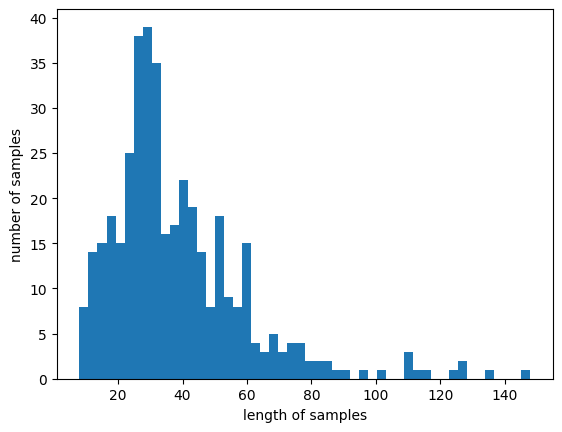

In [19]:
print("최대 길이 :", max(len(review) for review in X_train))
print("평균 길이 :", sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if len(sentence) <= max_len:
            count = count + 1
    print(
        "전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s"
        % (max_len, (count / len(nested_list)) * 100)
    )

In [21]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 43.43434343434344


In [22]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [35]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128
best_model_path = "best_model.keras"

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(32, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(5, activation="softmax"))

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=4)
mc = ModelCheckpoint(
    best_model_path,
    monitor="val_acc",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
print(model.summary())

history = model.fit(
    X_train, y_train, epochs=15, batch_size=32, validation_split=0.2, callbacks=[es, mc]
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 100)         137200    
                                                                 
 lstm_9 (LSTM)               (None, 32)                17024     
                                                                 
 dense_9 (Dense)             (None, 5)                 165       
                                                                 
Total params: 154389 (603.08 KB)
Trainable params: 154389 (603.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/15
 5/10 [==============>...............] - ETA: 0s - loss: 1.6120 - acc: 0.2125 
Epoch 1: val_acc improved from -inf to 0.30000, saving model to best_model.keras
10/10 [==============================] - 2s 46ms/step - loss: 1.6085 - acc: 0.2184 - val_loss: 1.5962 

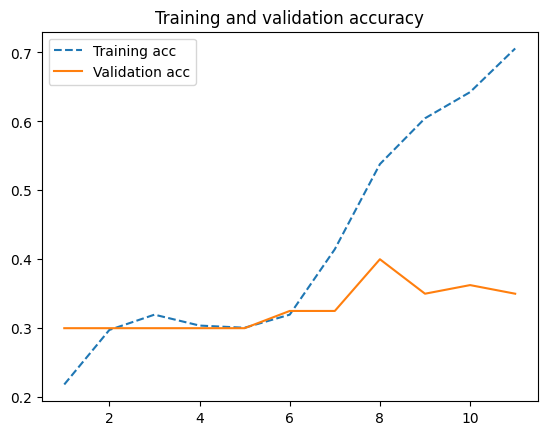

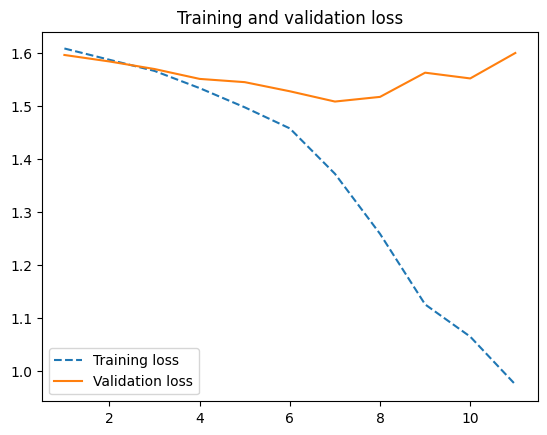

In [36]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "--", label="Training acc")
plt.plot(epochs, val_acc, label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "--", label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

훈련 결과 과대적합이 발생한 것으로 보인다. 훈련에서도 성능이 높지 않은 것을 볼 수 있다.